# Adaptive PDE discretizations on Cartesian grids, Taichi implementations

## Volume : Algorithm tools

## Part : Symmetric matrix decompositions

## Chapter : Selling's decomposition and variants
$
\newcommand\cS{\mathcal{S}}
\newcommand\bZ{\mathbb{Z}}
\newcommand\Id{\mathrm{Id}}
\DeclareMathOperator\Tr{Tr}
$


Give a symmetric matrix $D \in \cS_d^{++}$, where $d \in \{2,3\}$, Selling's decomposition definies a finite collection $E \subset \bZ^d$ of offsets with integer coordinates, of cardinality $d(d+1)/2$, and $(\lambda^e)_{e \in E}$ of *non-negative* weights, such that 
$$
    D = \sum_{e \in E} \lambda^e e e^\top. 
$$
This decomposition has a rich mathematical structure, and generalizes into Voronoi's first reduction of positive quadratic forms in higher dimension, but these will not be developed in this notebook.

**Smooth coefficients.** One limitation of Selling's decomposition is that the coefficients $\lambda^e = \lambda^e(D)$ depend piecewise linearly on the matrix $D$. In some applications to PDE discretizations, a decomposition with smoothly varying coefficients is needed, see the options proposed below.

**Python vs Taichi implementation.**
The agd library contains a Python implementation of Selling's decomposition, but often also relies on C++ (CPU) and a CUDA (GPU) implementations for speed. The purpose of the agdt library is to replace these multiple implementations with a single one.

## 0. Importing the required libraries

In [1]:
# Replace the following lines with pip install agd, agdt, unless you downloaded the libraries on your computer.
import sys
sys.path.insert(0,"/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AGDT/AdaptiveGridDiscretizations_Taichi")
sys.path.insert(0,"/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations")

from agdt import Selling
from agd import Selling as pySelling

[Taichi] version 1.7.2, llvm 15.0.7, commit 0131dce9, osx, python 3.11.11


[I 03/27/25 00:52:53.379 5352160] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import taichi as ti
float_t = ti.f64
ti.init(arch=ti.cpu,default_fp=float_t)
np.set_printoptions(linewidth=2000)

[Taichi] Starting on arch=arm64


## 1. Random positive definite matrices 

We will use random symmetric positive definite matrices in order to test our codes.
They are generated as 
$$
M = A^\top A + r \Tr(A^\top A) \Id,
$$
where $A$ has independent random coefficients in $[-1,1]$, and $r>0$ is a parameter ensuring positive definiteness. Here is a python code.

In [3]:
def pyRandomSym(ndim,relax=0.1,shape=tuple()):
    """Generate random symmetric matrices"""
    A = 2*np.random.rand(*shape,ndim,ndim)-1
    M = np.swapaxes(A,-1,-2) @ A
    trM = sum(M[...,i,i] for i in range(ndim))
    M += relax*trM[...,None,None]*np.eye(ndim)
    return M

In [4]:
m = pyRandomSym(3)
print(m)
np.linalg.eigvalsh(m)

[[ 1.67847527 -0.54593094  0.50606971]
 [-0.54593094  1.00402859 -0.66171663]
 [ 0.50606971 -0.66171663  1.03477584]]


array([0.35600928, 0.93755588, 2.42371453])

The agdt library functions are a little more cumbersome to use, because many of them involve some preprocessing - at least defining the types involved. For that reason, we rely on factory functions. 

In [5]:
RandomSym = Selling.mk_RandomSym(3,float_t) # Only once ! Constructs the function

In addition, they can only be called:
- within taichi scope (i.e. in a kernel)
- within a loop, usually (the outermost loop is parallelized, which is incompatible with e.g. break statements)

In [6]:
@ti.kernel # Function must be called within a kernel
def test_RandomSym():
    for _ in range(1): # Most functions need to be called within an inner loop
        m = RandomSym(0.1)
        print(m)
test_RandomSym()

[[1.090293302085, 0.224592728262, 0.492299129742], [0.224592728262, 0.473462120826, 0.326389182924], [0.492299129742, 0.326389182924, 1.054880985990]]


For convenience, the agdt library usually bundles taichi functions with some type information.

In [7]:
RandomSym.types

namespace(ndim=3,
          float_t=<taichi._lib.core.taichi_python.DataType at 0x105ab4130>,
          mat_t=<taichi.lang.matrix.MatrixType at 0x150d31050>)

The floating point type is the one we provided.

In [8]:
print(RandomSym.types.float_t)

f64


The matrix type (3x3, floating point) can be reconstructed as follows.

In [9]:
mat_t = ti.lang.matrix.MatrixType(3,3,2,float_t);
#mat_t = RandomSym.types.mat_t # Equivalent

Generate a bunch of random matrices using Taichi, organized into a field.

In [10]:
m = ti.field(dtype=mat_t,shape=(5,)) # Generate the field container
@ti.kernel
def test_RandomField():
    for I in m: m[I] = RandomSym(0.1)
test_RandomField()

In [11]:
print(m)

[[[ 2.56737168  0.74159876  2.28237001]
  [ 0.74159876  1.21633892  0.44867431]
  [ 2.28237001  0.44867431  2.28012717]]

 [[ 1.22745682  0.85308485  0.40933917]
  [ 0.85308485  1.36380932  0.3868796 ]
  [ 0.40933917  0.3868796   0.26546261]]

 [[ 1.60976145  0.43616799  0.39564347]
  [ 0.43616799  1.1331274   0.47960295]
  [ 0.39564347  0.47960295  1.19793986]]

 [[ 1.51017511  0.72385858  0.06093323]
  [ 0.72385858  1.40699487  0.25937589]
  [ 0.06093323  0.25937589  0.16203725]]

 [[ 1.54957988  0.11274527 -0.28852018]
  [ 0.11274527  1.72655504 -0.42744373]
  [-0.28852018 -0.42744373  0.48035371]]]


**Random seed.**
Setting the taichi random seed requires restarting the taichi engine. Results are not deterministic anyway due to parallelization.
For this reason, we rely on numpy for reproducibility.

In [12]:
np.random.seed(42)
pyRandomSym(3,shape=(4,))

array([[[ 1.22653529, -1.00920993, -0.43091749],
        [-1.00920993,  2.16568633,  1.03968147],
        [-0.43091749,  1.03968147,  1.07302102]],

       [[ 1.3872271 , -0.53363177, -0.06334947],
        [-0.53363177,  1.77468351, -0.55440728],
        [-0.06334947, -0.55440728,  1.66170106]],

       [[ 0.71618662,  0.30645297,  0.21503426],
        [ 0.30645297,  0.8425404 , -0.32488015],
        [ 0.21503426, -0.32488015,  0.65234686]],

       [[ 1.26793536,  0.69959008,  0.34081049],
        [ 0.69959008,  1.75050039,  0.97996041],
        [ 0.34081049,  0.97996041,  2.37485348]]])

## 2. Selling's decomposition

Given a symmetric positive definite matrix $D\in \cS_d^{++}$, Selling's decomposition defines a collection of offsets $E(D) \subset \bZ^d$, and of weights $(\lambda^e(D))_{e \in E(D)}$, such that 
$$
    D = \sum_{e \in E(D)} \lambda^e e e^\top.
$$
We show below how to construct the weights, offsets, and to check the reconstruction formula.

**Common stencil.**
Given a family $(D_i)_{i \in I}$ of symmetric positive definite matrices, one may need for some applications a common stencil, and corresponding coefficients:
\begin{align*}
    E &:= \cup_{i \in I} E(D_i),&
    \lambda^e(D) := 0 \text{ for any } e \in E \setminus E(D_i).
\end{align*}
The `DecompWithFixedOffsets' function is devoted to regrouping. (Note that opposite offsets are regarded as equal.)
Using a common stencil $E$ as above is not recommended if the anisotropy is strong.


In [13]:
np.random.seed(42) # Reproducibility
for ndim in (2,3):
    # Define a symmetric matrix type
    mat_t = ti.lang.matrix.MatrixType(ndim,ndim,2,float_t)
    m = ti.field(mat_t,4)
    m.from_numpy(pyRandomSym(m.n,shape=m.shape))

    # Build the Selling decomposition routine
    Sel = Selling.mk_Selling(m.n,m.dtype)    
    λ = ti.field(Sel.types.weights_t,m.shape) # Weights
    e = ti.field(Sel.types.offsets_t,m.shape) # Offsets
    
    @ti.kernel
    def test_Selling():
        for I in m:
            λ[I],e[I] = Sel(m[I])
    test_Selling()
    print("Weights and offsets associated to the first matrix of the field")
    print(λ[0])
    print(e[0])

    Reconstruct = Selling.mk_Reconstruct(m.n,m.dtype)
    m_rec = ti.field(mat_t,m.shape)
    @ti.kernel
    def test_Reconstruct():
        for I in m_rec:
            m_rec[I] = Reconstruct(λ[I],e[I])
    test_Reconstruct()
    assert np.allclose(m_rec.to_numpy(),m.to_numpy())
    print("Reconstruction test passed")

    Λ_,E_ = Selling.DecompWithFixedOffsets(λ.to_numpy(),e.to_numpy())
    print("Weights associated to the first matrix of the field, common offsets")
    print(Λ_[0,:])
    print(E_)
    nE = len(E_)
    Λ = ti.field(ti.lang.matrix.VectorType(nE,float_t),m.shape); Λ.from_numpy(Λ_)
    E = ti.field(ti.lang.matrix.MatrixType(nE,m.n,2,e.dtype),shape=tuple()); E.from_numpy(E_)
    m_rec.fill(0)

    @ti.kernel
    def test_FixedOffsets():
        for I in m_rec:
            m_rec[I] = Reconstruct(Λ[I],E[None])
    test_FixedOffsets()
    assert np.allclose(m_rec.to_numpy(),m.to_numpy())
    print("Fixed offsets test passed")
    print("-------------------------\n")


Weights and offsets associated to the first matrix of the field
[0.82984926 0.25658721 0.13463357]
[[ 0  1]
 [-1  0]
 [ 1 -1]]
Reconstruction test passed
Weights associated to the first matrix of the field, common offsets
[0.13463357 0.25658721 0.82984926 0.        ]
[[ 1 -1]
 [-1  0]
 [ 0  1]
 [-1 -1]]
Fixed offsets test passed
-------------------------

Weights and offsets associated to the first matrix of the field
[0.14286898 0.00168193 0.09642925 0.22662238 0.12941654 0.38918429]
[[ 0  1 -1]
 [ 1 -1  1]
 [ 0  1  0]
 [-1  0  0]
 [ 0  0 -1]
 [ 1  0  1]]
Reconstruction test passed
Weights associated to the first matrix of the field, common offsets
[0.         0.         0.14286898 0.         0.         0.22662238
 0.09642925 0.         0.00168193 0.12941654 0.38918429 0.        ]
[[-1  1  1]
 [-1  0  1]
 [ 0  1 -1]
 [ 1  1 -1]
 [-1  1  0]
 [-1  0  0]
 [ 0  1  0]
 [-1 -1  0]
 [ 1 -1  1]
 [ 0  0 -1]
 [ 1  0  1]
 [ 0 -1 -1]]
Fixed offsets test passed
-------------------------



## 3. Smooth variants

Smooth variants of Selling's decomposition are required by some numerical schemes to achieve high order convergence rates.

### 3.1 Two dimensional

The following smooth two-dimensional variant of Selling's decomposition uses $4$ positive weights, instead of $3$ for the original version, for generic positive definite matrices. It is described in:
* Bonnans, F., Bonnet, G. & Mirebeau, J.-M. Monotone Discretization of Anisotropic Differential Operators Using Voronoi’s First Reduction. Constr. Approx. 1–61 (2023) doi:10.1007/s00365-023-09672-y.
  

In [4]:
np.random.seed(36)
mat_t = ti.lang.matrix.MatrixType(2,2,2,float_t)
nT = 50
T = ti.field(float_t,nT); T.from_numpy(np.linspace(0,1,nT))
m = ti.field(mat_t,2); m.from_numpy(pyRandomSym(mat_t.n,shape=(2,)))

Sel = Selling.mk_Selling(mat_t.n,mat_t.dtype)
sSel = Selling.mk_SmoothSelling2(mat_t.n,mat_t.dtype)

λ  = ti.field( Sel.types.weights_t,T.shape)
e  = ti.field( Sel.types.offsets_t,T.shape)
sλ = ti.field(sSel.types.weights_t,T.shape)
se = ti.field(sSel.types.offsets_t,T.shape)

@ti.kernel
def test_SmoothSelling():
    for i in T:
        mi = (1-T[i])*m[0] + T[i]*m[1] # 
        λ[i], e[i]  =  Sel(mi)
        sλ[i],se[i] = sSel(mi)
test_SmoothSelling()

Λ,E = Selling.DecompWithFixedOffsets(λ.to_numpy(),e.to_numpy())
sΛ,sE = Selling.DecompWithFixedOffsets(sλ.to_numpy(),se.to_numpy())

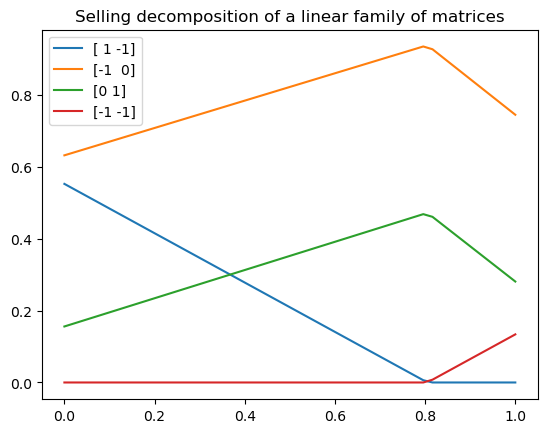

In [5]:
plt.title("Selling decomposition of a linear family of matrices")
for λi,ei in zip(Λ.T,E):
    plt.plot(T.to_numpy(),λi,label=f"{ei}")
plt.legend();

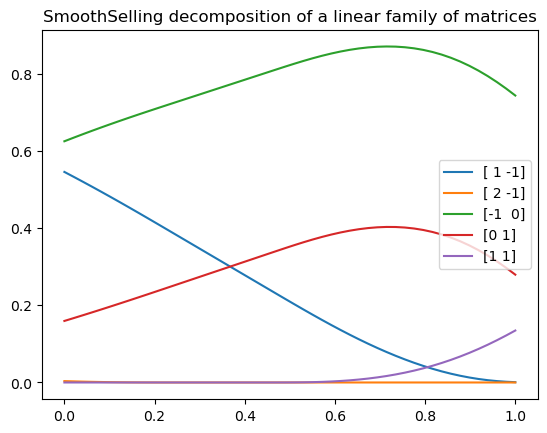

In [6]:
plt.title("SmoothSelling decomposition of a linear family of matrices")
for λi,ei in zip(sΛ.T,sE):
    plt.plot(T.to_numpy(),λi,label=f"{ei}")
plt.legend();

### 3.2 Three dimensional

In [4]:
np.random.seed(36)
mat_t = ti.lang.matrix.MatrixType(3,3,2,float_t)
nT = 50
T = ti.field(float_t,nT); T.from_numpy(np.linspace(0,1,nT))
m = ti.field(mat_t,2); m.from_numpy(pyRandomSym(mat_t.n,shape=(2,)))

Sel = Selling.mk_Selling(mat_t.n,mat_t.dtype)
sSel = Selling.mk_SmoothSelling3(mat_t.n,mat_t.dtype)

λ  = ti.field( Sel.types.weights_t,T.shape)
e  = ti.field( Sel.types.offsets_t,T.shape)
sλ = ti.field(sSel.types.weights_t,T.shape)
se = ti.field(sSel.types.offsets_t,T.shape)

@ti.kernel
def test_SmoothSelling():
    for i in T:
        mi = (1-T[i])*m[0] + T[i]*m[1] # 
        λ[i], e[i]  =  Sel(mi)
        sλ[i],se[i] = sSel(mi)
test_SmoothSelling()

Λ,E = Selling.DecompWithFixedOffsets(λ.to_numpy(),e.to_numpy())
sΛ,sE = Selling.DecompWithFixedOffsets(sλ.to_numpy(),se.to_numpy())

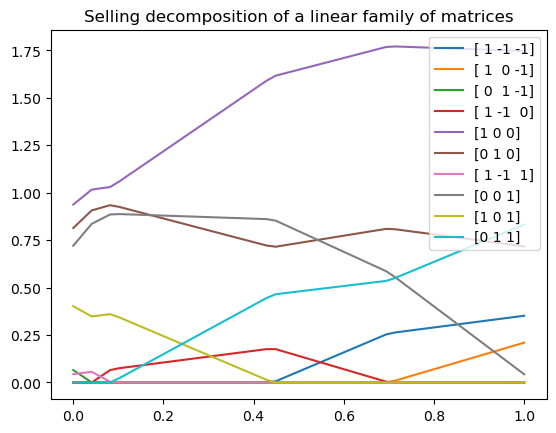

In [5]:
plt.title("Selling decomposition of a linear family of matrices")
for λi,ei in zip(Λ.T,E):
    plt.plot(T.to_numpy(),λi,label=f"{ei}")
plt.legend();

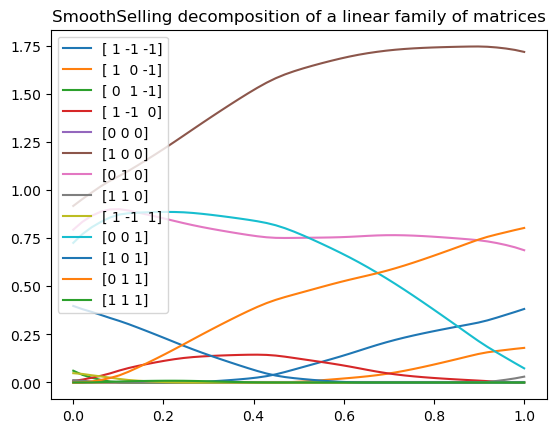

In [6]:
plt.title("SmoothSelling decomposition of a linear family of matrices")
for λi,ei in zip(sΛ.T,sE):
    plt.plot(T.to_numpy(),λi,label=f"{ei}")
plt.legend();